# Montly DACON Machine Fault Diagnosis
## -  Anomaly Detection

## Library Import

In [1]:
# ! pip install librosa

In [47]:
import random
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
import librosa
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore') 

In [48]:
CFG = {
    'SR':16000,
    'N_MFCC':128, # MFCC 벡터를 추출할 개수 (<=128)
    'SEED':41
}

In [49]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(CFG['SEED']) # Seed 고정

In [50]:
train_df = pd.read_csv('./train.csv') # 모두 정상 Sample
test_df = pd.read_csv('./test.csv')

In [51]:
train_df

,SAMPLE_ID,SAMPLE_PATH,FAN_TYPE,LABEL
0,TRAIN_0000,./train/TRAIN_0000.wav,2,0
1,TRAIN_0001,./train/TRAIN_0001.wav,0,0
2,TRAIN_0002,./train/TRAIN_0002.wav,0,0
3,TRAIN_0003,./train/TRAIN_0003.wav,2,0
4,TRAIN_0004,./train/TRAIN_0004.wav,2,0
...,...,...,...,...
1274,TRAIN_1274,./train/TRAIN_1274.wav,2,0
1275,TRAIN_1275,./train/TRAIN_1275.wav,2,0
1276,TRAIN_1276,./train/TRAIN_1276.wav,2,0
1277,TRAIN_1277,./train/TRAIN_1277.wav,2,0


In [76]:
train_df['LABEL'].unique()

array([0], dtype=int64)

In [52]:
train_df['FAN_TYPE'].unique()

array([2, 0], dtype=int64)

In [53]:
train_label = train_df[['FAN_TYPE','LABEL']]
train_label

,FAN_TYPE,LABEL
0,2,0
1,0,0
2,0,0
3,2,0
4,2,0
...,...,...
1274,2,0
1275,2,0
1276,2,0
1277,2,0


In [54]:
test_df

,SAMPLE_ID,SAMPLE_PATH,FAN_TYPE
0,TEST_0000,./test/TEST_0000.wav,2
1,TEST_0001,./test/TEST_0001.wav,2
2,TEST_0002,./test/TEST_0002.wav,0
3,TEST_0003,./test/TEST_0003.wav,0
4,TEST_0004,./test/TEST_0004.wav,0
...,...,...,...
1509,TEST_1509,./test/TEST_1509.wav,0
1510,TEST_1510,./test/TEST_1510.wav,2
1511,TEST_1511,./test/TEST_1511.wav,0
1512,TEST_1512,./test/TEST_1512.wav,0


In [55]:
id_test = test_df['SAMPLE_ID']
id_test

0       TEST_0000
1       TEST_0001
2       TEST_0002
3       TEST_0003
4       TEST_0004
          ...    
1509    TEST_1509
1510    TEST_1510
1511    TEST_1511
1512    TEST_1512
1513    TEST_1513
Name: SAMPLE_ID, Length: 1514, dtype: object

In [56]:
test_fan = test_df['FAN_TYPE']
test_fan

0       2
1       2
2       0
3       0
4       0
       ..
1509    0
1510    2
1511    0
1512    0
1513    2
Name: FAN_TYPE, Length: 1514, dtype: int64

In [57]:
def get_mfcc_feature(df):
    features = []
    for path in tqdm(df['SAMPLE_PATH']):
        # librosa패키지를 사용하여 wav 파일 load
        y, sr = librosa.load(path, sr=CFG['SR'])
        
        # librosa패키지를 사용하여 mfcc 추출
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=CFG['N_MFCC'])

        y_feature = []
        # 추출된 MFCC들의 평균을 Feature로 사용
        for e in mfcc:
            y_feature.append(np.mean(e))
        features.append(y_feature)
    return features

In [58]:
train_features = get_mfcc_feature(train_df)
test_features = get_mfcc_feature(test_df)

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1514 [00:00<?, ?it/s]

## EDA

In [178]:
train_features = pd.DataFrame(train_features)
train_features

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,-332.822968,96.714211,-14.923252,21.968349,-8.564011,-2.027139,-11.869205,3.885383,-5.751901,3.539213,...,0.539370,0.663468,0.523915,-0.309364,-0.818508,-0.129562,0.530418,0.116271,-0.800855,-0.867277
1,-438.514435,142.282898,-2.122107,30.592234,0.737141,15.533080,-2.803471,4.224413,-1.894261,3.574963,...,0.178568,-0.044237,0.042868,0.374269,0.762829,0.738473,0.288381,0.002098,0.344611,0.157145
2,-419.292419,123.302338,10.127716,21.659258,-1.092546,11.255920,-3.392200,1.564470,3.889135,3.802191,...,0.462635,0.319143,0.199252,0.078277,0.520589,0.860090,0.382899,-0.062304,-0.115386,-0.302028
3,-333.860535,97.461487,-13.956148,22.239996,-9.348626,-2.875100,-11.314520,6.395192,-2.481325,3.891461,...,0.078985,0.460926,-0.021310,0.223788,-0.586876,-0.260907,-0.127185,0.113592,-0.935072,-0.169548
4,-333.146606,90.000252,-21.705933,14.738313,-18.315386,-9.914182,-16.343977,2.563049,-6.700718,-0.878550,...,0.055402,0.145843,-0.031247,0.558820,-0.543790,-0.374026,-0.223215,0.091165,-0.612550,-0.216651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1274,-331.278717,83.516144,-24.639460,17.099073,-17.417221,-9.260210,-16.640516,-0.968224,-8.006650,-0.210976,...,-0.178437,-0.041334,-0.172667,-0.083145,-0.373329,0.001631,-0.215286,-0.068310,-0.687748,-0.080964
1275,-331.944550,96.614929,-15.033259,22.885084,-9.548154,-3.824131,-13.007987,5.053965,-3.507394,4.024566,...,0.308821,0.210678,0.629672,0.535989,-0.188029,-0.090514,0.081146,0.166000,0.017817,-0.548864
1276,-335.417572,92.459663,-19.939020,14.659496,-14.785930,-6.819523,-14.032729,1.931983,-8.374944,0.402798,...,-0.494620,-0.082534,0.327789,0.258334,-0.339538,-0.661168,-0.750548,-0.497419,-0.981388,-1.050707
1277,-335.176880,94.095650,-16.676874,17.122639,-13.769092,-7.083161,-12.534894,5.114513,-4.965012,0.256115,...,-0.174318,-0.098888,-0.008657,-0.311247,-0.878406,-0.427334,-0.186461,-0.092595,-0.752961,-0.147661


In [179]:
test_features = pd.DataFrame(test_features)
test_features

,1,2,3,4,5,6,7,8,9,10,...,118,119,120,121,122,123,124,125,126,127
0,93.499161,-14.531839,18.782629,-12.993633,-8.891464,-15.007888,2.987521,-4.080492,3.411654,-6.457707,...,0.164154,0.485382,0.375715,0.610794,0.073637,0.207322,0.096070,0.408414,-0.723793,-0.071414
1,98.042473,-14.108411,22.853271,-10.276470,-4.724311,-13.290108,5.331754,-3.047695,3.999879,-7.176520,...,0.103364,0.016831,0.042590,0.843998,0.041890,0.020773,-0.281918,0.173492,-0.634122,0.104590
2,146.174515,-9.374091,28.873428,-3.150095,14.049159,-3.056240,6.908220,-0.042742,4.407775,-5.706607,...,0.780984,0.600820,0.476922,0.563234,0.534703,0.684900,0.188768,0.328292,0.420767,-0.095793
3,149.789581,17.103006,15.994092,11.349452,14.492430,4.636677,7.593799,-0.623311,6.458681,9.799132,...,0.816981,0.770491,0.940058,0.350600,0.109936,0.470496,0.976864,-1.214070,-1.232217,-0.899378
4,147.652374,-8.984773,27.868708,-2.585596,14.579635,-2.599407,6.154584,-1.616730,5.772117,-1.521694,...,0.392530,0.168322,-0.095196,0.534444,0.721170,1.066953,0.719139,0.225388,-0.045223,-0.460058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1509,149.396683,15.755502,13.032166,12.392975,16.820803,6.094834,5.686713,-0.725644,6.116574,8.337746,...,1.001100,1.318711,0.423131,-0.261257,0.159387,0.486768,1.015050,-0.103403,0.325985,0.371032
1510,128.039993,7.505565,9.477396,-8.824609,3.085480,-6.793148,3.817405,-2.430128,-0.906629,-7.552742,...,-0.419314,0.330574,-0.324109,0.174071,-0.162393,-0.051136,0.150210,-0.030394,-0.762911,0.062790
1511,140.022720,-5.812835,33.935928,-1.197876,15.227143,-4.239627,4.924495,-3.108877,4.950400,0.489955,...,-0.119929,0.302331,0.258988,0.435238,0.395255,0.415199,-0.006936,0.052725,0.278880,0.126119
1512,142.657898,-6.374496,33.241409,-2.003935,14.646495,-4.510120,4.902259,-3.379752,5.055974,0.786986,...,0.076547,0.336713,0.479046,0.773436,0.756806,0.699998,-0.015126,-0.232445,0.278983,0.515977


In [61]:
train_features.describe()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
count,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,...,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000
mean,-377.995148,113.071587,-8.204121,23.844816,-5.696002,3.985400,-7.830544,4.918558,-3.314722,3.504721,...,0.234378,0.325420,0.187518,0.239336,-0.007590,0.230924,0.119021,0.099486,-0.224045,-0.076919
std,44.433617,20.116034,9.127360,6.379835,6.397071,9.715973,6.013824,1.850644,2.243773,1.990547,...,0.370404,0.429256,0.347362,0.349561,0.543606,0.440418,0.372824,0.358652,0.549388,0.402612
min,-448.470551,76.786301,-32.213192,9.417195,-18.516598,-11.760925,-20.303896,-5.875247,-12.201679,-1.488135,...,-0.919933,-0.801145,-1.379041,-1.058502,-1.417813,-0.976136,-0.999907,-1.490105,-1.982088,-1.442499
25%,-422.757462,96.079597,-15.300093,18.211165,-10.590346,-4.679994,-13.268520,4.101818,-4.322296,2.457698,...,0.033521,0.043346,-0.041060,0.003929,-0.397619,-0.090389,-0.130518,-0.058163,-0.623901,-0.332300
50%,-340.757111,98.747040,-12.232296,22.529516,-7.863924,-0.741084,-10.262085,5.039418,-3.339386,3.758240,...,0.193546,0.251227,0.190680,0.269571,-0.067489,0.200933,0.075717,0.133931,-0.311153,-0.044135
75%,-334.778168,133.674660,0.087004,30.151427,0.304949,14.362323,-2.352551,5.795192,-2.380331,4.778134,...,0.373253,0.543552,0.408663,0.505621,0.435155,0.543489,0.325567,0.316944,0.255672,0.183964
max,-327.026825,146.801788,26.229727,43.937645,9.320456,21.310450,5.242990,14.517347,6.673819,15.678004,...,1.999650,2.045654,1.464702,1.327185,1.503646,1.570143,1.681078,1.487185,1.195769,1.074005


In [93]:
# train data 스케일링
from sklearn import preprocessing

cols = train_features.columns
scaler = preprocessing.MinMaxScaler()
np_scaled = scaler.fit_transform(train_features)

train_features_scale = pd.DataFrame(np_scaled, columns = cols)
train_features_scale

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.952273,0.284621,0.295843,0.363586,0.357530,0.294327,0.330165,0.478636,0.341701,0.292864,...,0.499833,0.514477,0.669173,0.314013,0.205139,0.332475,0.570807,0.539543,0.371707,0.228580
1,0.081981,0.935459,0.514880,0.613406,0.691659,0.825306,0.685032,0.495261,0.546074,0.294947,...,0.376253,0.265880,0.500013,0.600570,0.746422,0.673378,0.480528,0.501195,0.732160,0.635661
2,0.240260,0.664368,0.724483,0.354632,0.625930,0.695975,0.661987,0.364824,0.852471,0.308184,...,0.473550,0.393526,0.555005,0.476499,0.663505,0.721141,0.515783,0.479564,0.587409,0.453196
3,0.943729,0.295295,0.312391,0.371455,0.329344,0.268686,0.351878,0.601711,0.514972,0.313384,...,0.342144,0.443330,0.477445,0.537493,0.284425,0.280892,0.325523,0.538643,0.329472,0.505841
4,0.949608,0.188729,0.179787,0.154144,0.007228,0.055841,0.155006,0.413792,0.291434,0.035511,...,0.334066,0.332650,0.473951,0.677927,0.299173,0.236467,0.289704,0.531111,0.430963,0.487123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1274,0.964989,0.096119,0.129592,0.222531,0.039493,0.075616,0.143398,0.240628,0.222247,0.074400,...,0.253973,0.266900,0.424220,0.408837,0.357521,0.383998,0.292661,0.477547,0.407300,0.541042
1275,0.959506,0.283203,0.293961,0.390142,0.322177,0.239990,0.285589,0.535940,0.460612,0.321138,...,0.420866,0.355425,0.706362,0.668357,0.420948,0.347810,0.403230,0.556246,0.629325,0.355110
1276,0.930908,0.223856,0.210020,0.151861,0.134018,0.149416,0.245477,0.382846,0.202736,0.110155,...,0.145676,0.252428,0.600205,0.551973,0.369088,0.123697,0.093010,0.333419,0.314898,0.155689
1277,0.932890,0.247222,0.265837,0.223214,0.170546,0.141445,0.304108,0.538909,0.383390,0.101610,...,0.255384,0.246683,0.481895,0.313224,0.184636,0.215531,0.303413,0.469390,0.386779,0.514538


(array([  0.5,   3.5,   6.5,   9.5,  12.5,  15.5,  18.5,  21.5,  24.5,
         27.5,  30.5,  33.5,  36.5,  39.5,  42.5,  45.5,  48.5,  51.5,
         54.5,  57.5,  60.5,  63.5,  66.5,  69.5,  72.5,  75.5,  78.5,
         81.5,  84.5,  87.5,  90.5,  93.5,  96.5,  99.5, 102.5, 105.5,
        108.5, 111.5, 114.5, 117.5, 120.5, 123.5, 126.5]),
 [Text(0, 0.5, '0'),
  Text(0, 3.5, '3'),
  Text(0, 6.5, '6'),
  Text(0, 9.5, '9'),
  Text(0, 12.5, '12'),
  Text(0, 15.5, '15'),
  Text(0, 18.5, '18'),
  Text(0, 21.5, '21'),
  Text(0, 24.5, '24'),
  Text(0, 27.5, '27'),
  Text(0, 30.5, '30'),
  Text(0, 33.5, '33'),
  Text(0, 36.5, '36'),
  Text(0, 39.5, '39'),
  Text(0, 42.5, '42'),
  Text(0, 45.5, '45'),
  Text(0, 48.5, '48'),
  Text(0, 51.5, '51'),
  Text(0, 54.5, '54'),
  Text(0, 57.5, '57'),
  Text(0, 60.5, '60'),
  Text(0, 63.5, '63'),
  Text(0, 66.5, '66'),
  Text(0, 69.5, '69'),
  Text(0, 72.5, '72'),
  Text(0, 75.5, '75'),
  Text(0, 78.5, '78'),
  Text(0, 81.5, '81'),
  Text(0, 84.5, '84')

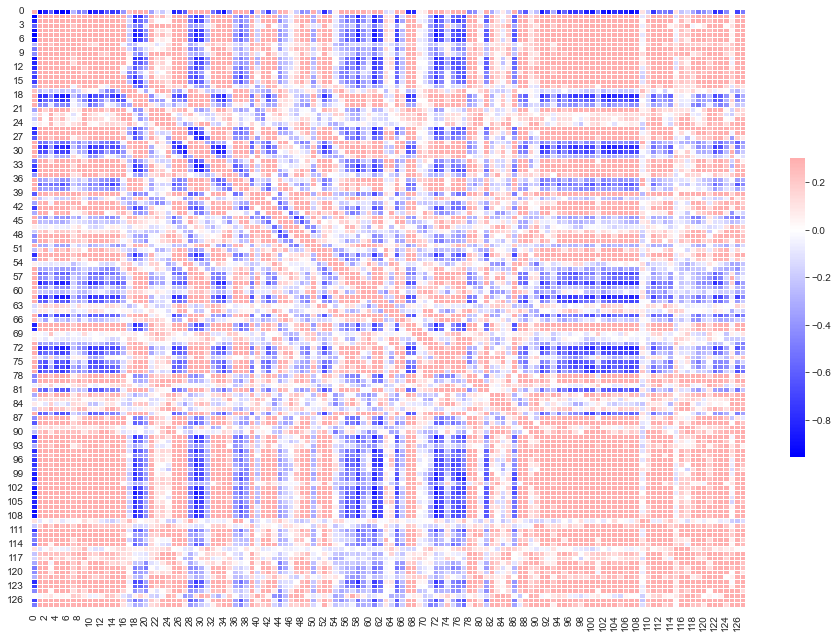

In [111]:
corr =  train_features_scale.corr()

f, ax=  plt.subplots(figsize = (16,11))

sns.heatmap(corr, cmap = 'bwr', vmax =.3, center = 0,
           linewidths = .5, cbar_kws = {'shrink' : .5})

plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

In [132]:
# 상관계수 높은 변수 제거
train_lowcor_features = train_features_scale.drop(columns=
                                    [0,18,19,20,28,29,30,36,37,38,44,55,56,57,58,59,60,61,
                                     62,65,71,72,73,74,75,76,77,81,86])
train_lowcor_features

,1,2,3,4,5,6,7,8,9,10,...,118,119,120,121,122,123,124,125,126,127
0,0.284621,0.295843,0.363586,0.357530,0.294327,0.330165,0.478636,0.341701,0.292864,0.318002,...,0.499833,0.514477,0.669173,0.314013,0.205139,0.332475,0.570807,0.539543,0.371707,0.228580
1,0.935459,0.514880,0.613406,0.691659,0.825306,0.685032,0.495261,0.546074,0.294947,0.599122,...,0.376253,0.265880,0.500013,0.600570,0.746422,0.673378,0.480528,0.501195,0.732160,0.635661
2,0.664368,0.724483,0.354632,0.625930,0.695975,0.661987,0.364824,0.852471,0.308184,0.766975,...,0.473550,0.393526,0.555005,0.476499,0.663505,0.721141,0.515783,0.479564,0.587409,0.453196
3,0.295295,0.312391,0.371455,0.329344,0.268686,0.351878,0.601711,0.514972,0.313384,0.258289,...,0.342144,0.443330,0.477445,0.537493,0.284425,0.280892,0.325523,0.538643,0.329472,0.505841
4,0.188729,0.179787,0.154144,0.007228,0.055841,0.155006,0.413792,0.291434,0.035511,0.115548,...,0.334066,0.332650,0.473951,0.677927,0.299173,0.236467,0.289704,0.531111,0.430963,0.487123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1274,0.096119,0.129592,0.222531,0.039493,0.075616,0.143398,0.240628,0.222247,0.074400,0.124570,...,0.253973,0.266900,0.424220,0.408837,0.357521,0.383998,0.292661,0.477547,0.407300,0.541042
1275,0.283203,0.293961,0.390142,0.322177,0.239990,0.285589,0.535940,0.460612,0.321138,0.255913,...,0.420866,0.355425,0.706362,0.668357,0.420948,0.347810,0.403230,0.556246,0.629325,0.355110
1276,0.223856,0.210020,0.151861,0.134018,0.149416,0.245477,0.382846,0.202736,0.110155,0.252963,...,0.145676,0.252428,0.600205,0.551973,0.369088,0.123697,0.093010,0.333419,0.314898,0.155689
1277,0.247222,0.265837,0.223214,0.170546,0.141445,0.304108,0.538909,0.383390,0.101610,0.107619,...,0.255384,0.246683,0.481895,0.313224,0.184636,0.215531,0.303413,0.469390,0.386779,0.514538


(array([ 0.5,  2.5,  4.5,  6.5,  8.5, 10.5, 12.5, 14.5, 16.5, 18.5, 20.5,
        22.5, 24.5, 26.5, 28.5, 30.5, 32.5, 34.5, 36.5, 38.5, 40.5, 42.5,
        44.5, 46.5, 48.5, 50.5, 52.5, 54.5, 56.5, 58.5, 60.5, 62.5, 64.5,
        66.5, 68.5, 70.5, 72.5, 74.5, 76.5, 78.5, 80.5, 82.5, 84.5, 86.5,
        88.5, 90.5, 92.5, 94.5, 96.5, 98.5]),
 [Text(0, 0.5, '1'),
  Text(0, 2.5, '3'),
  Text(0, 4.5, '5'),
  Text(0, 6.5, '7'),
  Text(0, 8.5, '9'),
  Text(0, 10.5, '11'),
  Text(0, 12.5, '13'),
  Text(0, 14.5, '15'),
  Text(0, 16.5, '17'),
  Text(0, 18.5, '22'),
  Text(0, 20.5, '24'),
  Text(0, 22.5, '26'),
  Text(0, 24.5, '31'),
  Text(0, 26.5, '33'),
  Text(0, 28.5, '35'),
  Text(0, 30.5, '40'),
  Text(0, 32.5, '42'),
  Text(0, 34.5, '45'),
  Text(0, 36.5, '47'),
  Text(0, 38.5, '49'),
  Text(0, 40.5, '51'),
  Text(0, 42.5, '53'),
  Text(0, 44.5, '63'),
  Text(0, 46.5, '66'),
  Text(0, 48.5, '68'),
  Text(0, 50.5, '70'),
  Text(0, 52.5, '79'),
  Text(0, 54.5, '82'),
  Text(0, 56.5, '84'),
 

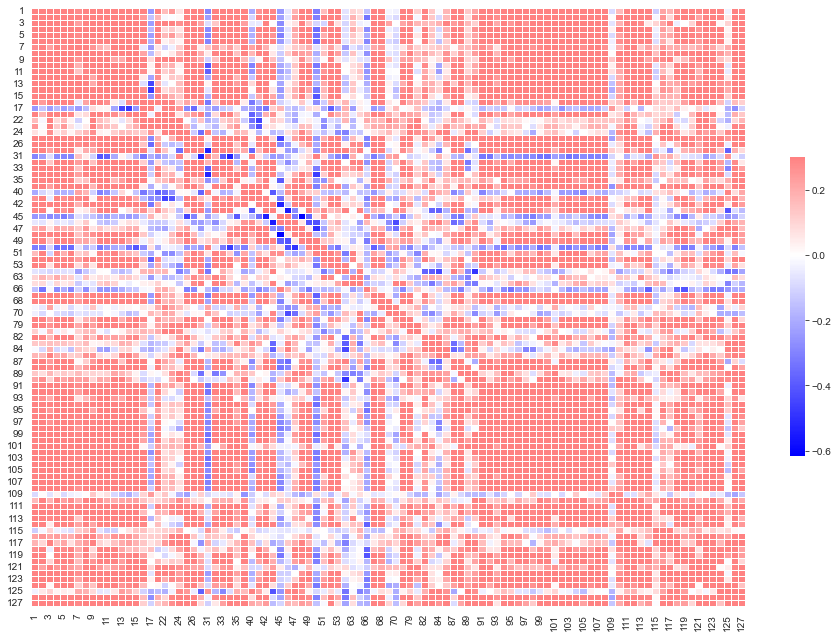

In [133]:
corr_low =  train_lowcor_features.corr()

f, ax=  plt.subplots(figsize = (16,11))

sns.heatmap(corr_low, cmap = 'bwr', vmax =.3, center = 0,
           linewidths = .5, cbar_kws = {'shrink' : .5})

plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

In [134]:
# total train
tot_train = pd.concat([train_lowcor_features,train_label],axis=1)
tot_train

,1,2,3,4,5,6,7,8,9,10,...,120,121,122,123,124,125,126,127,FAN_TYPE,LABEL
0,0.284621,0.295843,0.363586,0.357530,0.294327,0.330165,0.478636,0.341701,0.292864,0.318002,...,0.669173,0.314013,0.205139,0.332475,0.570807,0.539543,0.371707,0.228580,2,0
1,0.935459,0.514880,0.613406,0.691659,0.825306,0.685032,0.495261,0.546074,0.294947,0.599122,...,0.500013,0.600570,0.746422,0.673378,0.480528,0.501195,0.732160,0.635661,0,0
2,0.664368,0.724483,0.354632,0.625930,0.695975,0.661987,0.364824,0.852471,0.308184,0.766975,...,0.555005,0.476499,0.663505,0.721141,0.515783,0.479564,0.587409,0.453196,0,0
3,0.295295,0.312391,0.371455,0.329344,0.268686,0.351878,0.601711,0.514972,0.313384,0.258289,...,0.477445,0.537493,0.284425,0.280892,0.325523,0.538643,0.329472,0.505841,2,0
4,0.188729,0.179787,0.154144,0.007228,0.055841,0.155006,0.413792,0.291434,0.035511,0.115548,...,0.473951,0.677927,0.299173,0.236467,0.289704,0.531111,0.430963,0.487123,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1274,0.096119,0.129592,0.222531,0.039493,0.075616,0.143398,0.240628,0.222247,0.074400,0.124570,...,0.424220,0.408837,0.357521,0.383998,0.292661,0.477547,0.407300,0.541042,2,0
1275,0.283203,0.293961,0.390142,0.322177,0.239990,0.285589,0.535940,0.460612,0.321138,0.255913,...,0.706362,0.668357,0.420948,0.347810,0.403230,0.556246,0.629325,0.355110,2,0
1276,0.223856,0.210020,0.151861,0.134018,0.149416,0.245477,0.382846,0.202736,0.110155,0.252963,...,0.600205,0.551973,0.369088,0.123697,0.093010,0.333419,0.314898,0.155689,2,0
1277,0.247222,0.265837,0.223214,0.170546,0.141445,0.304108,0.538909,0.383390,0.101610,0.107619,...,0.481895,0.313224,0.184636,0.215531,0.303413,0.469390,0.386779,0.514538,2,0


In [149]:
tot_train = tot_train.drop(columns = ['LABEL'])

In [135]:
# PCA
from sklearn.decomposition import PCA

y = tot_train['LABEL']
X = tot_train.loc[:, tot_train.columns != 'LABEL']

pca = PCA(n_components = 2)
scaled_df = pca.fit_transform(X)
df_p = pd.DataFrame(data = scaled_df, columns = ['pca1', 'pca2'])

fdf = pd.concat([df_p, y], axis = 1)

pca.explained_variance_ratio_

array([0.6139378 , 0.04961413])

Text(0, 0.5, 'Principal Components 2')

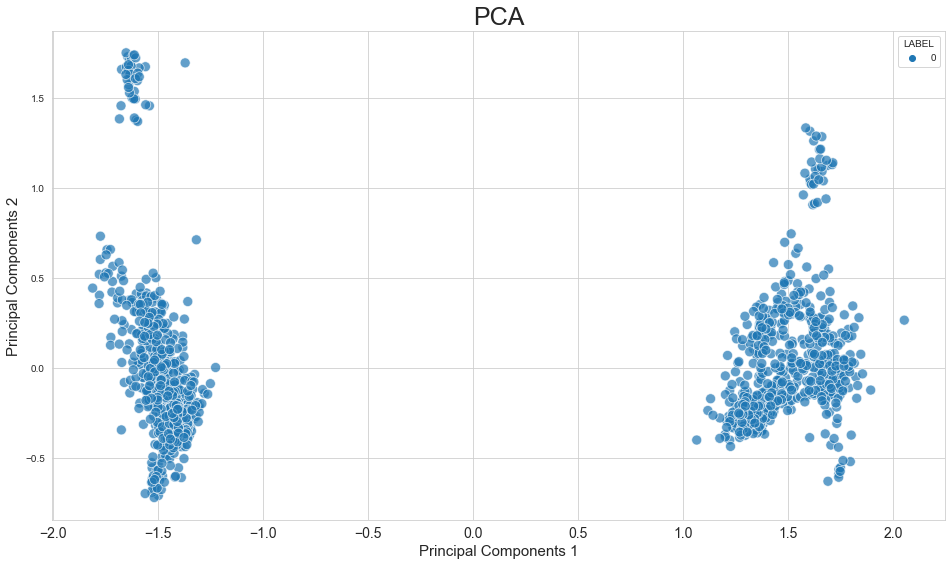

In [136]:
plt.figure(figsize= (16,9))
sns.scatterplot(x = 'pca1', y = 'pca2', data = fdf, hue = 'LABEL', alpha = 0.7,
               s = 100)

plt.title('PCA', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10)
plt.xlabel("Principal Components 1", fontsize = 15)
plt.ylabel("Principal Components 2", fontsize = 15)

Text(0, 0.5, 'Principal Components 2')

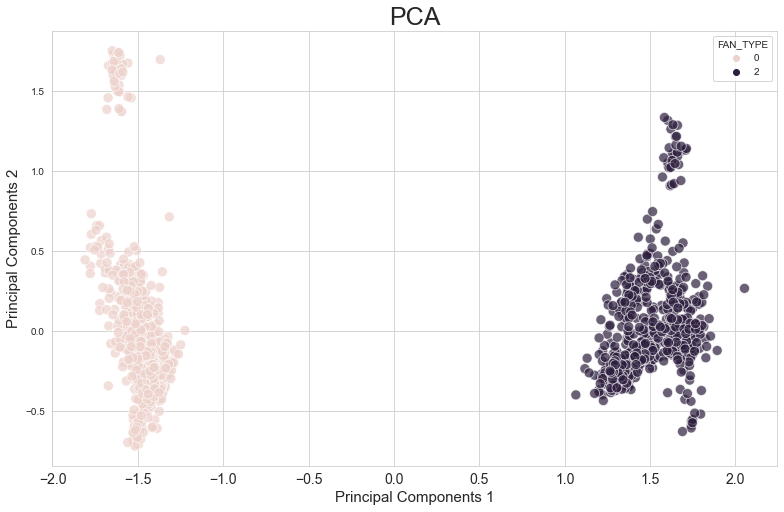

In [137]:
plt.figure(figsize= (13,8))
sns.scatterplot(x = 'pca1', y = 'pca2', data = fdf, hue = tot_train['FAN_TYPE'], alpha = 0.7,
               s = 100)

plt.title('PCA', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10)
plt.xlabel("Principal Components 1", fontsize = 15)
plt.ylabel("Principal Components 2", fontsize = 15)

In [138]:
# 2차원 t-SNE 임베딩
tsne_np = TSNE(n_components = 2).fit_transform(X)

# numpy array -> DataFrame 변환
tsne_df = pd.DataFrame(tsne_np, columns = ['component 0', 'component 1'])

In [139]:
tsne_df

,component 0,component 1
0,-10.668338,24.010885
1,18.412130,-10.579147
2,13.746325,-27.899933
3,-17.490368,23.881989
4,-38.106842,5.330240
...,...,...
1274,-39.656960,7.402333
1275,-12.325766,-0.813830
1276,-62.447475,2.633996
1277,-17.526684,37.837616


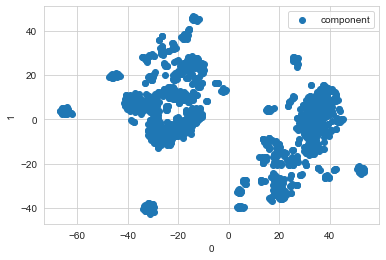

In [140]:
plt.scatter(tsne_df['component 0'], tsne_df['component 1'], label = "component")

plt.legend(loc = "best")
plt.xlabel('0')
plt.ylabel('1')
plt.show()

In [141]:
# concat
tsne_df = pd.concat([tsne_df,train_label],axis=1)
tsne_df

,component 0,component 1,FAN_TYPE,LABEL
0,-10.668338,24.010885,2,0
1,18.412130,-10.579147,0,0
2,13.746325,-27.899933,0,0
3,-17.490368,23.881989,2,0
4,-38.106842,5.330240,2,0
...,...,...,...,...
1274,-39.656960,7.402333,2,0
1275,-12.325766,-0.813830,2,0
1276,-62.447475,2.633996,2,0
1277,-17.526684,37.837616,2,0


<AxesSubplot:xlabel='component 0', ylabel='component 1'>

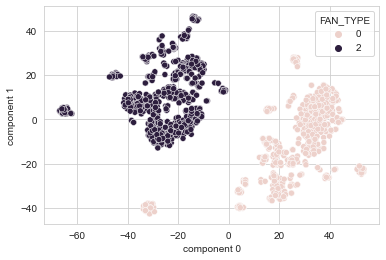

In [142]:
sns.set_style('whitegrid')
sns.scatterplot(data=tsne_df, x=tsne_df['component 0'], y=tsne_df['component 1'],
                hue= tsne_df['FAN_TYPE'], ## 각 요일별로 색상이 다르게 그려진다.
                hue_order = [0,2] ## 일, 토, 목, 금 순으로 색상과 범례가 표시
               )

In [146]:
test_features = test_features.drop(columns=
                                    [0,18,19,20,28,29,30,36,37,38,44,55,56,57,58,59,60,61,
                                     62,65,71,72,73,74,75,76,77,81,86])
test_features

,1,2,3,4,5,6,7,8,9,10,...,118,119,120,121,122,123,124,125,126,127
0,93.499161,-14.531839,18.782629,-12.993633,-8.891464,-15.007888,2.987521,-4.080492,3.411654,-6.457707,...,0.164154,0.485382,0.375715,0.610794,0.073637,0.207322,0.096070,0.408414,-0.723793,-0.071414
1,98.042473,-14.108411,22.853271,-10.276470,-4.724311,-13.290108,5.331754,-3.047695,3.999879,-7.176520,...,0.103364,0.016831,0.042590,0.843998,0.041890,0.020773,-0.281918,0.173492,-0.634122,0.104590
2,146.174515,-9.374091,28.873428,-3.150095,14.049159,-3.056240,6.908220,-0.042742,4.407775,-5.706607,...,0.780984,0.600820,0.476922,0.563234,0.534703,0.684900,0.188768,0.328292,0.420767,-0.095793
3,149.789581,17.103006,15.994092,11.349452,14.492430,4.636677,7.593799,-0.623311,6.458681,9.799132,...,0.816981,0.770491,0.940058,0.350600,0.109936,0.470496,0.976864,-1.214070,-1.232217,-0.899378
4,147.652374,-8.984773,27.868708,-2.585596,14.579635,-2.599407,6.154584,-1.616730,5.772117,-1.521694,...,0.392530,0.168322,-0.095196,0.534444,0.721170,1.066953,0.719139,0.225388,-0.045223,-0.460058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1509,149.396683,15.755502,13.032166,12.392975,16.820803,6.094834,5.686713,-0.725644,6.116574,8.337746,...,1.001100,1.318711,0.423131,-0.261257,0.159387,0.486768,1.015050,-0.103403,0.325985,0.371032
1510,128.039993,7.505565,9.477396,-8.824609,3.085480,-6.793148,3.817405,-2.430128,-0.906629,-7.552742,...,-0.419314,0.330574,-0.324109,0.174071,-0.162393,-0.051136,0.150210,-0.030394,-0.762911,0.062790
1511,140.022720,-5.812835,33.935928,-1.197876,15.227143,-4.239627,4.924495,-3.108877,4.950400,0.489955,...,-0.119929,0.302331,0.258988,0.435238,0.395255,0.415199,-0.006936,0.052725,0.278880,0.126119
1512,142.657898,-6.374496,33.241409,-2.003935,14.646495,-4.510120,4.902259,-3.379752,5.055974,0.786986,...,0.076547,0.336713,0.479046,0.773436,0.756806,0.699998,-0.015126,-0.232445,0.278983,0.515977


In [170]:
cols = test_features.columns
scaler = preprocessing.MinMaxScaler()
np_scaled = scaler.fit_transform(test_features)

test_features_scale = pd.DataFrame(np_scaled, columns = cols)
test_features_scale

,1,2,3,4,5,6,7,8,9,10,...,118,119,120,121,122,123,124,125,126,127
0,0.242300,0.221555,0.288590,0.199509,0.068129,0.152605,0.228201,0.324285,0.361059,0.315161,...,0.366094,0.436806,0.490269,0.558831,0.498686,0.418055,0.475392,0.594808,0.393473,0.440693
1,0.283258,0.228293,0.382006,0.283496,0.181452,0.207604,0.334949,0.375747,0.381596,0.286103,...,0.344596,0.291931,0.372086,0.633858,0.488856,0.360016,0.364592,0.525378,0.420801,0.494040
2,0.717169,0.303621,0.520161,0.503773,0.691987,0.535272,0.406735,0.525479,0.395837,0.345524,...,0.584225,0.472500,0.526174,0.543530,0.641449,0.566640,0.502564,0.571129,0.742286,0.433303
3,0.749759,0.724902,0.224597,0.951954,0.704041,0.781583,0.437954,0.496550,0.467441,0.972341,...,0.596955,0.524962,0.690481,0.475120,0.509926,0.499934,0.733579,0.115285,0.238527,0.189736
4,0.730492,0.309816,0.497104,0.521221,0.706413,0.549899,0.372417,0.447050,0.443471,0.514699,...,0.446855,0.338772,0.323204,0.534267,0.699186,0.685505,0.658032,0.540715,0.600272,0.322894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1509,0.746217,0.703462,0.156624,0.984209,0.767360,0.828270,0.351112,0.491451,0.455497,0.913265,...,0.662066,0.694471,0.507091,0.278271,0.525237,0.504997,0.744773,0.443542,0.713401,0.574799
1510,0.553686,0.572196,0.075047,0.328373,0.393835,0.415624,0.265991,0.406520,0.210293,0.270895,...,0.159759,0.388940,0.241993,0.418326,0.425603,0.337643,0.491262,0.465119,0.381552,0.481370
1511,0.661710,0.360285,0.636339,0.564116,0.724021,0.497382,0.316403,0.372699,0.414782,0.596019,...,0.265632,0.380207,0.448858,0.502350,0.598271,0.482730,0.445198,0.489685,0.699045,0.500565
1512,0.685466,0.351348,0.620401,0.539200,0.708231,0.488722,0.315391,0.359202,0.418468,0.608027,...,0.335113,0.390838,0.526928,0.611157,0.710220,0.571337,0.442797,0.405403,0.699076,0.618732


In [171]:
tot_test = pd.concat([test_features_scale,test_fan],axis=1)
tot_test

,1,2,3,4,5,6,7,8,9,10,...,119,120,121,122,123,124,125,126,127,FAN_TYPE
0,0.242300,0.221555,0.288590,0.199509,0.068129,0.152605,0.228201,0.324285,0.361059,0.315161,...,0.436806,0.490269,0.558831,0.498686,0.418055,0.475392,0.594808,0.393473,0.440693,2
1,0.283258,0.228293,0.382006,0.283496,0.181452,0.207604,0.334949,0.375747,0.381596,0.286103,...,0.291931,0.372086,0.633858,0.488856,0.360016,0.364592,0.525378,0.420801,0.494040,2
2,0.717169,0.303621,0.520161,0.503773,0.691987,0.535272,0.406735,0.525479,0.395837,0.345524,...,0.472500,0.526174,0.543530,0.641449,0.566640,0.502564,0.571129,0.742286,0.433303,0
3,0.749759,0.724902,0.224597,0.951954,0.704041,0.781583,0.437954,0.496550,0.467441,0.972341,...,0.524962,0.690481,0.475120,0.509926,0.499934,0.733579,0.115285,0.238527,0.189736,0
4,0.730492,0.309816,0.497104,0.521221,0.706413,0.549899,0.372417,0.447050,0.443471,0.514699,...,0.338772,0.323204,0.534267,0.699186,0.685505,0.658032,0.540715,0.600272,0.322894,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1509,0.746217,0.703462,0.156624,0.984209,0.767360,0.828270,0.351112,0.491451,0.455497,0.913265,...,0.694471,0.507091,0.278271,0.525237,0.504997,0.744773,0.443542,0.713401,0.574799,0
1510,0.553686,0.572196,0.075047,0.328373,0.393835,0.415624,0.265991,0.406520,0.210293,0.270895,...,0.388940,0.241993,0.418326,0.425603,0.337643,0.491262,0.465119,0.381552,0.481370,2
1511,0.661710,0.360285,0.636339,0.564116,0.724021,0.497382,0.316403,0.372699,0.414782,0.596019,...,0.380207,0.448858,0.502350,0.598271,0.482730,0.445198,0.489685,0.699045,0.500565,0
1512,0.685466,0.351348,0.620401,0.539200,0.708231,0.488722,0.315391,0.359202,0.418468,0.608027,...,0.390838,0.526928,0.611157,0.710220,0.571337,0.442797,0.405403,0.699076,0.618732,0


# 스케일링 안 한걸로

In [180]:
train_lowcor_features = train_features.drop(columns=
                                    [0,18,19,20,28,29,30,36,37,38,44,55,56,57,58,59,60,61,
                                     62,65,71,72,73,74,75,76,77,81,86])
train_lowcor_features

,1,2,3,4,5,6,7,8,9,10,...,118,119,120,121,122,123,124,125,126,127
0,96.714211,-14.923252,21.968349,-8.564011,-2.027139,-11.869205,3.885383,-5.751901,3.539213,-5.868282,...,0.539370,0.663468,0.523915,-0.309364,-0.818508,-0.129562,0.530418,0.116271,-0.800855,-0.867277
1,142.282898,-2.122107,30.592234,0.737141,15.533080,-2.803471,4.224413,-1.894261,3.574963,1.131873,...,0.178568,-0.044237,0.042868,0.374269,0.762829,0.738473,0.288381,0.002098,0.344611,0.157145
2,123.302338,10.127716,21.659258,-1.092546,11.255920,-3.392200,1.564470,3.889135,3.802191,5.311592,...,0.462635,0.319143,0.199252,0.078277,0.520589,0.860090,0.382899,-0.062304,-0.115386,-0.302028
3,97.461487,-13.956148,22.239996,-9.348626,-2.875100,-11.314520,6.395192,-2.481325,3.891461,-7.355210,...,0.078985,0.460926,-0.021310,0.223788,-0.586876,-0.260907,-0.127185,0.113592,-0.935072,-0.169548
4,90.000252,-21.705933,14.738313,-18.315386,-9.914182,-16.343977,2.563049,-6.700718,-0.878550,-10.909599,...,0.055402,0.145843,-0.031247,0.558820,-0.543790,-0.374026,-0.223215,0.091165,-0.612550,-0.216651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1274,83.516144,-24.639460,17.099073,-17.417221,-9.260210,-16.640516,-0.968224,-8.006650,-0.210976,-10.684933,...,-0.178437,-0.041334,-0.172667,-0.083145,-0.373329,0.001631,-0.215286,-0.068310,-0.687748,-0.080964
1275,96.614929,-15.033259,22.885084,-9.548154,-3.824131,-13.007987,5.053965,-3.507394,4.024566,-7.414376,...,0.308821,0.210678,0.629672,0.535989,-0.188029,-0.090514,0.081146,0.166000,0.017817,-0.548864
1276,92.459663,-19.939020,14.659496,-14.785930,-6.819523,-14.032729,1.931983,-8.374944,0.402798,-7.487813,...,-0.494620,-0.082534,0.327789,0.258334,-0.339538,-0.661168,-0.750548,-0.497419,-0.981388,-1.050707
1277,94.095650,-16.676874,17.122639,-13.769092,-7.083161,-12.534894,5.114513,-4.965012,0.256115,-11.107038,...,-0.174318,-0.098888,-0.008657,-0.311247,-0.878406,-0.427334,-0.186461,-0.092595,-0.752961,-0.147661


In [181]:
# total train
tot_train = pd.concat([train_lowcor_features,train_label],axis=1)
tot_train

,1,2,3,4,5,6,7,8,9,10,...,120,121,122,123,124,125,126,127,FAN_TYPE,LABEL
0,96.714211,-14.923252,21.968349,-8.564011,-2.027139,-11.869205,3.885383,-5.751901,3.539213,-5.868282,...,0.523915,-0.309364,-0.818508,-0.129562,0.530418,0.116271,-0.800855,-0.867277,2,0
1,142.282898,-2.122107,30.592234,0.737141,15.533080,-2.803471,4.224413,-1.894261,3.574963,1.131873,...,0.042868,0.374269,0.762829,0.738473,0.288381,0.002098,0.344611,0.157145,0,0
2,123.302338,10.127716,21.659258,-1.092546,11.255920,-3.392200,1.564470,3.889135,3.802191,5.311592,...,0.199252,0.078277,0.520589,0.860090,0.382899,-0.062304,-0.115386,-0.302028,0,0
3,97.461487,-13.956148,22.239996,-9.348626,-2.875100,-11.314520,6.395192,-2.481325,3.891461,-7.355210,...,-0.021310,0.223788,-0.586876,-0.260907,-0.127185,0.113592,-0.935072,-0.169548,2,0
4,90.000252,-21.705933,14.738313,-18.315386,-9.914182,-16.343977,2.563049,-6.700718,-0.878550,-10.909599,...,-0.031247,0.558820,-0.543790,-0.374026,-0.223215,0.091165,-0.612550,-0.216651,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1274,83.516144,-24.639460,17.099073,-17.417221,-9.260210,-16.640516,-0.968224,-8.006650,-0.210976,-10.684933,...,-0.172667,-0.083145,-0.373329,0.001631,-0.215286,-0.068310,-0.687748,-0.080964,2,0
1275,96.614929,-15.033259,22.885084,-9.548154,-3.824131,-13.007987,5.053965,-3.507394,4.024566,-7.414376,...,0.629672,0.535989,-0.188029,-0.090514,0.081146,0.166000,0.017817,-0.548864,2,0
1276,92.459663,-19.939020,14.659496,-14.785930,-6.819523,-14.032729,1.931983,-8.374944,0.402798,-7.487813,...,0.327789,0.258334,-0.339538,-0.661168,-0.750548,-0.497419,-0.981388,-1.050707,2,0
1277,94.095650,-16.676874,17.122639,-13.769092,-7.083161,-12.534894,5.114513,-4.965012,0.256115,-11.107038,...,-0.008657,-0.311247,-0.878406,-0.427334,-0.186461,-0.092595,-0.752961,-0.147661,2,0


In [182]:
tot_train = tot_train.drop(columns = ['LABEL'])

In [184]:
test_features

,1,2,3,4,5,6,7,8,9,10,...,118,119,120,121,122,123,124,125,126,127
0,93.499161,-14.531839,18.782629,-12.993633,-8.891464,-15.007888,2.987521,-4.080492,3.411654,-6.457707,...,0.164154,0.485382,0.375715,0.610794,0.073637,0.207322,0.096070,0.408414,-0.723793,-0.071414
1,98.042473,-14.108411,22.853271,-10.276470,-4.724311,-13.290108,5.331754,-3.047695,3.999879,-7.176520,...,0.103364,0.016831,0.042590,0.843998,0.041890,0.020773,-0.281918,0.173492,-0.634122,0.104590
2,146.174515,-9.374091,28.873428,-3.150095,14.049159,-3.056240,6.908220,-0.042742,4.407775,-5.706607,...,0.780984,0.600820,0.476922,0.563234,0.534703,0.684900,0.188768,0.328292,0.420767,-0.095793
3,149.789581,17.103006,15.994092,11.349452,14.492430,4.636677,7.593799,-0.623311,6.458681,9.799132,...,0.816981,0.770491,0.940058,0.350600,0.109936,0.470496,0.976864,-1.214070,-1.232217,-0.899378
4,147.652374,-8.984773,27.868708,-2.585596,14.579635,-2.599407,6.154584,-1.616730,5.772117,-1.521694,...,0.392530,0.168322,-0.095196,0.534444,0.721170,1.066953,0.719139,0.225388,-0.045223,-0.460058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1509,149.396683,15.755502,13.032166,12.392975,16.820803,6.094834,5.686713,-0.725644,6.116574,8.337746,...,1.001100,1.318711,0.423131,-0.261257,0.159387,0.486768,1.015050,-0.103403,0.325985,0.371032
1510,128.039993,7.505565,9.477396,-8.824609,3.085480,-6.793148,3.817405,-2.430128,-0.906629,-7.552742,...,-0.419314,0.330574,-0.324109,0.174071,-0.162393,-0.051136,0.150210,-0.030394,-0.762911,0.062790
1511,140.022720,-5.812835,33.935928,-1.197876,15.227143,-4.239627,4.924495,-3.108877,4.950400,0.489955,...,-0.119929,0.302331,0.258988,0.435238,0.395255,0.415199,-0.006936,0.052725,0.278880,0.126119
1512,142.657898,-6.374496,33.241409,-2.003935,14.646495,-4.510120,4.902259,-3.379752,5.055974,0.786986,...,0.076547,0.336713,0.479046,0.773436,0.756806,0.699998,-0.015126,-0.232445,0.278983,0.515977


In [185]:
tot_test = pd.concat([test_features,test_fan],axis=1)
tot_test

,1,2,3,4,5,6,7,8,9,10,...,119,120,121,122,123,124,125,126,127,FAN_TYPE
0,93.499161,-14.531839,18.782629,-12.993633,-8.891464,-15.007888,2.987521,-4.080492,3.411654,-6.457707,...,0.485382,0.375715,0.610794,0.073637,0.207322,0.096070,0.408414,-0.723793,-0.071414,2
1,98.042473,-14.108411,22.853271,-10.276470,-4.724311,-13.290108,5.331754,-3.047695,3.999879,-7.176520,...,0.016831,0.042590,0.843998,0.041890,0.020773,-0.281918,0.173492,-0.634122,0.104590,2
2,146.174515,-9.374091,28.873428,-3.150095,14.049159,-3.056240,6.908220,-0.042742,4.407775,-5.706607,...,0.600820,0.476922,0.563234,0.534703,0.684900,0.188768,0.328292,0.420767,-0.095793,0
3,149.789581,17.103006,15.994092,11.349452,14.492430,4.636677,7.593799,-0.623311,6.458681,9.799132,...,0.770491,0.940058,0.350600,0.109936,0.470496,0.976864,-1.214070,-1.232217,-0.899378,0
4,147.652374,-8.984773,27.868708,-2.585596,14.579635,-2.599407,6.154584,-1.616730,5.772117,-1.521694,...,0.168322,-0.095196,0.534444,0.721170,1.066953,0.719139,0.225388,-0.045223,-0.460058,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1509,149.396683,15.755502,13.032166,12.392975,16.820803,6.094834,5.686713,-0.725644,6.116574,8.337746,...,1.318711,0.423131,-0.261257,0.159387,0.486768,1.015050,-0.103403,0.325985,0.371032,0
1510,128.039993,7.505565,9.477396,-8.824609,3.085480,-6.793148,3.817405,-2.430128,-0.906629,-7.552742,...,0.330574,-0.324109,0.174071,-0.162393,-0.051136,0.150210,-0.030394,-0.762911,0.062790,2
1511,140.022720,-5.812835,33.935928,-1.197876,15.227143,-4.239627,4.924495,-3.108877,4.950400,0.489955,...,0.302331,0.258988,0.435238,0.395255,0.415199,-0.006936,0.052725,0.278880,0.126119,0
1512,142.657898,-6.374496,33.241409,-2.003935,14.646495,-4.510120,4.902259,-3.379752,5.055974,0.786986,...,0.336713,0.479046,0.773436,0.756806,0.699998,-0.015126,-0.232445,0.278983,0.515977,0


## Modeling 
### - Isolation Forest

In [186]:
model  = IsolationForest(n_estimators = 200, max_samples = 256, contamination = 'auto',
                        random_state= CFG['SEED'], verbose = 0)
model.fit(tot_train)

IsolationForest(max_samples=256, n_estimators=200, random_state=41)

In [187]:
def get_pred_label(model_pred):
    # IsolationForest 모델 출력 (1:정상, -1:불량) 이므로 (0:정상, 1:불량)로 Label 변환
    model_pred = np.where(model_pred == 1, 0, model_pred)
    model_pred = np.where(model_pred == -1, 1, model_pred)
    return model_pred

In [188]:
test_pred = model.predict(tot_test) # model prediction
test_pred = get_pred_label(test_pred)

# Modeling 
## - Threshold

In [192]:
model  = IsolationForest(n_estimators = 200, max_samples = 256, contamination = 'auto',
                        random_state= CFG['SEED'], verbose = 0)
model.fit(tot_train)

IsolationForest(max_samples=256, n_estimators=200, random_state=41)

In [193]:
test_pred_proba = model.decision_function(tot_test)

In [194]:
threshold = 0.05
pred = (test_pred_proba < threshold)*1

In [195]:
pred.mean()

0.5964332892998679

# Submission

In [196]:
submit = pd.read_csv('./sample_submission.csv')
submit

,SAMPLE_ID,LABEL
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,0
3,TEST_0003,0
4,TEST_0004,0
...,...,...
1509,TEST_1509,0
1510,TEST_1510,0
1511,TEST_1511,0
1512,TEST_1512,0


In [197]:
submit['LABEL'] = pred
submit

,SAMPLE_ID,LABEL
0,TEST_0000,1
1,TEST_0001,0
2,TEST_0002,1
3,TEST_0003,1
4,TEST_0004,1
...,...,...
1509,TEST_1509,1
1510,TEST_1510,1
1511,TEST_1511,0
1512,TEST_1512,0


In [198]:
submit.to_csv('./submit_threshold.csv', index=False)